# This notebook finetunes a fine-tuned LLM from Hugging Face Transformers library on a dataset.

In [1]:
import pandas as pd
train = pd.read_csv("/home/ildar/Documents/practice_code/Jupityer_random/data/reviews_train.csv")
test = pd.read_csv("/home/ildar/Documents/practice_code/Jupityer_random/data/reviews_test.csv")

In [2]:
train.head(5)

,review,label
0,Based on all the negative comments about Taste...,good
1,I still have not received this. Obviously I c...,bad
2,</tr>The magazine is not worth the cost of sub...,good
3,This magazine is basically ads. Kindve worthle...,bad
4,"The only thing I've recieved, so far, is the b...",bad


## The task is sentiment analysis. We will use the fine-tuned distilBERT model from Hugging Face

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, tqdm


data = train["review"]
data_y = train["label"].apply(lambda x:1 if x=="good" else 0)


checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, data, targets):
        self.tokenizer = tokenizer
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data[idx]
        tokens = self.tokenizer(sentence, truncation=True, max_length=15)
        return tokens, self.targets[idx]

dataset = MyDataset(tokenizer, data, data_y)



def collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = [item[1].item() for item in batch]
    i = tokenizer.pad(sequences, padding="longest", return_tensors="pt")
    return i, torch.LongTensor(labels)



2025-08-18 10:54:35.337203: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 10:54:35.345230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755507275.355124  201647 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755507275.358045  201647 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 10:54:35.368416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## We will use skorch library to take advantage of Bayesian hyperparameter tuning offered by skopt library

In [3]:
from skorch import NeuralNetBinaryClassifier, NeuralNetClassifier
from transformers import AutoModelForSequenceClassification
import torch
import torch.nn as nn


class MyCustomDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset=dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=10, prefetch_factor=2, 
                 collate_fn=collate_fn, multiprocessing_context='fork'):
        super().__init__(dataset=dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory,
                        prefetch_factor=prefetch_factor, collate_fn=collate_fn, num_workers=num_workers,
                        multiprocessing_context=multiprocessing_context)

class MyCustomDataLoaderValid(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, pin_memory=True, collate_fn=collate_fn, num_workers=10, 
                 prefetch_factor=2, multiprocessing_context='fork'):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory, collate_fn=collate_fn, 
                        num_workers=num_workers, prefetch_factor=prefetch_factor,
                        multiprocessing_context=multiprocessing_context)
        


class DistilBert(nn.Module):
    def __init__(self):
        super().__init__()
        checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
        #device = torch.device("cuda:0")
        #model.to(device)
        self.net = model

    def forward(self,input_ids, attention_mask):
        device = torch.device("cuda:0")
        input_ids=input_ids.to(device, non_blocking=True)
        attention_mask = attention_mask.to(device, non_blocking=True)
        outputs = self.net(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits


est = NeuralNetClassifier(module=DistilBert, criterion = nn.CrossEntropyLoss, optimizer=torch.optim.Adam, 
                            device="cuda:0", max_epochs=5, iterator_train = MyCustomDataLoader, train_split=None,
                         iterator_valid = MyCustomDataLoaderValid)


## We will perform hyperparameter search on ``learning rate" and ``L2-regularization"

In [4]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.decomposition import NMF 
import os

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

grid_params = {"optimizer__weight_decay" : Real(10**-5, 10**0, prior="log-uniform"), 
               "optimizer__lr" : Real(10**-5, 10**0, prior="log-uniform")
              }

bayes = BayesSearchCV(est, grid_params, n_iter=2, n_jobs=2, cv=3, pre_dispatch=2, return_train_score=True)

In [5]:
from skorch.helper import SliceDataset


X_bayes = SliceDataset(dataset, idx=0)
y_bayes = SliceDataset(dataset, idx=1)

bayes.fit(X_bayes, y_bayes)

2025-08-18 10:55:11.085368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-18 10:55:11.085751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755507311.095801  285845 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755507311.096091  285844 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755507311.098971  285845 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1755507311.099274  285844 cuda_blas.cc:1

  epoch    train_loss      dur
-------  ------------  -------
      1        1.7580  11.9896
  epoch    train_loss      dur
-------  ------------  -------
      1        1.7621  12.0119
      2        0.8337  11.5463
      2        0.8526  11.5905
      3        0.6708  11.5941
      3        0.6870  11.6301
      4        0.6205  11.6047
      4        0.6242  11.6742
      5        0.6008  11.7108
      5        0.5993  11.7210
  epoch    train_loss     dur
-------  ------------  ------
      1        1.7331  5.7332
      2        0.8335  5.7156
      3        0.6735  5.7396
      4        0.6187  5.7371
      5        0.6030  5.7367
  epoch    train_loss      dur
-------  ------------  -------
      1        1.4482  11.8427
  epoch    train_loss      dur
-------  ------------  -------
      1        1.4634  11.8752
      2        0.6492  11.9018
      2        0.6413  11.9044
      3        0.5795  11.8718
      3        0.5768  11.9780
      4        0.5576  11.8855
      4        

BayesSearchCV(cv=3,
              estimator=NeuralNetClassifier(_params_to_validate=set(), batch_size=128, callbacks=None, compile=False, criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, dataset=<class 'skorch.dataset.Dataset'>, device='cuda:0', iterator_train=<class '__main__.MyCustomDataLoader'>, iterator_valid=<class '__main__.MyCustomDataLoaderValid'>, lr=0.01,...nlinearity='auto', torch_load_kwargs=None, train_split=None, use_caching='auto', verbose=1, warm_start=False),
              n_iter=2, n_jobs=2, pre_dispatch=2, return_train_score=True,
              search_spaces={'optimizer__lr': Real(low=1e-05, high=1, prior='log-uniform', transform='normalize'),
                             'optimizer__weight_decay': Real(low=1e-05, high=1, prior='log-uniform', transform='normalize')})

In [6]:
bayes.best_params_

OrderedDict([('optimizer__lr', 1.1215628606773627e-05),
             ('optimizer__weight_decay', 0.013975131074453764)])

In [9]:
bestest = bayes.best_estimator_


import skorch

bestest.train_split = skorch.dataset.ValidSplit(5)

## Train the best model one more time to get a generalization error.

In [10]:
bestest.fit(X_bayes, y_bayes)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3530       0.6312        0.6833  7.2984
      2        0.6235       0.6837        0.5824  7.3307
      3        0.5734       0.7174        0.5587  7.3178
      4        0.5473       0.7466        0.5452  7.3529
      5        0.5228       0.7819        0.5072  7.3821


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DistilBert(
    (net): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): Linear(in_features=768, out_features=768, bias=True)
                (k_lin): Linear(in_features=768, out_features=768, bias=True)
                (v_lin): Linear(in_features=768, out_features=768, bias=True)
                (out_lin): Linear(in_features=768, out_features=768, bias=True)
              )
              (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (ffn): FFN(
                (dropout): Dropout(p=0.1, inplace=False)
                (lin1): Linear(in_features=768, out_features=3072, bias=True)
                (lin2): Linear(in_features=3072, out_features=768, bias=True)
                (activation): GELUActivation()
              )
              (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            )
          )
        )
      )
      (pre_classifier): Linear(in_features=768, out_features=768, bias=True)
      (classifier): Linear(in_features=768, out_features=2, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  ),
)

In [11]:
import matplotlib.pyplot as plt

train_loss = bestest.history[:, "train_loss"]
valid_loss = bestest.history[:, "valid_loss"]

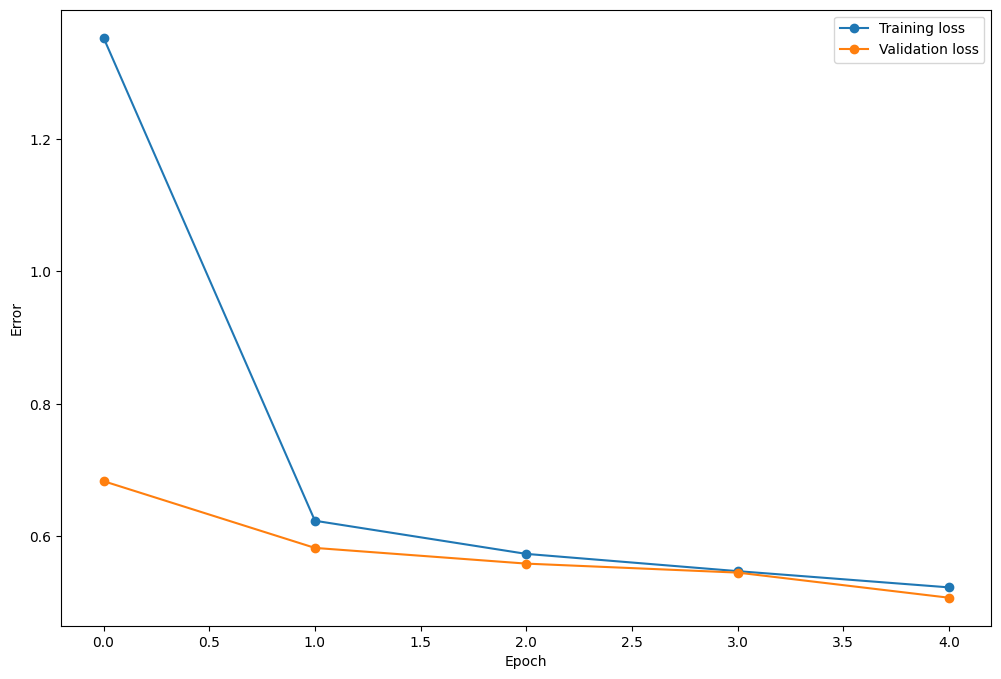

In [12]:
plt.figure(figsize=(12,8))
plt.plot(train_loss, "o-", label="Training loss")
plt.plot(valid_loss, "o-", label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

## Let's calculate the test error

In [13]:
#evaluate accuracy_prediction on test set

data_test = test["review"]
data_test_y = test["label"].apply(lambda x:1 if x=="good" else 0)

bestest.module_.eval()  ##this part is so important...it closes of layer_normalization....

dataset = MyDataset(tokenizer, data_test, data_test_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True, 
                                         prefetch_factor=2, num_workers=10)


device = torch.device("cuda:0")

y_pred = torch.tensor([]).to(device)

for batch in tqdm.tqdm(dataloader):
    batch = {k:v for k, v in batch[0].items()}
    output = bestest.module_(**batch)
    output = output.argmax(-1)
    y_pred = torch.cat((y_pred, output), dim=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 26.17it/s]


In [14]:
#after training

from sklearn.metrics import accuracy_score

accuracy_score(data_test_y, y_pred.to(torch.device("cpu")).numpy())

0.909

## Let's calculate the training error

In [15]:
#evalaute training error

data_train = train["review"]
data_train_y = train["label"].apply(lambda x:1 if x=="good" else 0)


dataset = MyDataset(tokenizer, data_train, data_train_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, collate_fn=collate_fn, pin_memory=True, 
                                         prefetch_factor=2, num_workers=10)



y_pred = torch.tensor([]).to(device)

for batch in tqdm.tqdm(dataloader):
    batch = {k:v for k, v in batch[0].items()}
    output = bestest.module_(**batch)
    output = output.argmax(-1)
    y_pred = torch.cat((y_pred, output), dim=-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:03<00:00, 67.78it/s]


In [16]:
accuracy_score(data_train_y, y_pred.to(torch.device("cpu")).numpy())

0.8012301230123012

## Let's compare the test error (after training) and the zero-shot classification test error

In [20]:
#zero classifcation

data_test = test["review"]
data_test_y = test["label"].apply(lambda x:1 if x=="good" else 0)


dataset = MyDataset(tokenizer, data_test, data_test_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True, 
                                         prefetch_factor=2, num_workers=10)


y_pred = torch.tensor([]).to(device)
model.to(device)

for batch in tqdm.tqdm(dataloader):
    batch = {k:v.to(device, non_blocking=True) for k, v in batch[0].items()}
    output = model(**batch)
    output = output.logits.argmax(-1)
    y_pred = torch.cat((y_pred, output), dim=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 28.37it/s]


In [21]:
accuracy_score(data_test_y, y_pred.to(torch.device("cpu")).numpy())

0.914

## Let's do the same for training error (after training) vs zero-shot

In [23]:
#zero classifcation

data_train = train["review"]
data_train_y = train["label"].apply(lambda x:1 if x=="good" else 0)


dataset = MyDataset(tokenizer, data_train, data_train_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, collate_fn=collate_fn, pin_memory=False, 
                                         prefetch_factor=2, num_workers=10)



y_pred = torch.tensor([]).to(device)
model.to(device)

for batch in tqdm.tqdm(dataloader):
    batch = {k:v.to(device, non_blocking=True) for k, v in batch[0].items()}
    output = model(**batch)
    output = output.logits.argmax(-1)
    y_pred = torch.cat((y_pred, output), dim=-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:02<00:00, 38.97it/s]


In [24]:
accuracy_score(data_train_y, y_pred.to(torch.device("cpu")).numpy())

0.588058805880588